# Install depends

In [ ]:
!pip install image_ocr
!pip install h5py

# Imports

In [2]:
import random
import string
import h5py
import math
import itertools
import os
import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import image_ocr as keras_ocr
import scipy.io
import tarfile
import urllib.request
from google.colab import drive

# Mount Drive (Optional) and Define Dataset Functions

In [3]:
drive.mount('/content/drive')
def download_and_extract(url, extract_path, split):
    """Download and extract the tar.gz file."""
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    filename = os.path.join(extract_path, url.split('/')[-1])

    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(path=extract_path)
        # Move files from the internal folder to the main folder
        internal_folder = os.path.join(extract_path, split)
        for item in os.listdir(internal_folder):
            os.rename(os.path.join(internal_folder, item), os.path.join(extract_path, item))
        os.rmdir(internal_folder)

def extract_digit_struct(mat_file):
    """Extracts the bounding boxes and labels from the digitStruct.mat file."""
    with h5py.File(mat_file, 'r') as f:
        names = f['digitStruct']['name']
        boxes = f['digitStruct']['bbox']
        dataset = []

        for i in range(len(names)):
            image_name = ''.join([chr(c[0]) for c in f[names[i][0]]])
            bbox = f[boxes[i].item()]

            # Check if there are multiple bounding boxes
            if len(bbox['label']) > 1:
                label = [int(f[bbox['label'][j].item()][0][0]) for j in range(len(bbox['label']))]
                top = [int(f[bbox['top'][j].item()][0][0]) for j in range(len(bbox['top']))]
                left = [int(f[bbox['left'][j].item()][0][0]) for j in range(len(bbox['left']))]
                height = [int(f[bbox['height'][j].item()][0][0]) for j in range(len(bbox['height']))]
                width = [int(f[bbox['width'][j].item()][0][0]) for j in range(len(bbox['width']))]
            else:
                label = [int(bbox['label'][0][0])]
                top = [int(bbox['top'][0][0])]
                left = [int(bbox['left'][0][0])]
                height = [int(bbox['height'][0][0])]
                width = [int(bbox['width'][0][0])]

            # Convert labels from MATLAB's 1-indexing to 0-indexing
            label = [l if l != 10 else 0 for l in label]
            word = ''.join(map(str, label))

            # Calculate bounding box around the entire number
            x1 = min(left)
            y1 = min(top)
            x2 = max(left) + max(width)
            y2 = max(top) + max(height)

            # Convert the bounding box to the format expected by keras_ocr
            bbox = np.array([
                [x1, y1],
                [x2, y1],
                [x2, y2],
                [x1, y2]
            ]).astype("float32")

            dataset.append((image_name, bbox, word))

        return dataset

def get_svhn_dataset(split='train'):
    """Download, extract, and process the SVHN dataset."""

    # Define URLs and paths
    base_url = "http://ufldl.stanford.edu/housenumbers/"
    download_path = f"{split}.tar.gz"
    extract_path = f"{split}_svhn"
    mat_file = os.path.join(extract_path, f"{split}/digitStruct.mat")

    # Download the dataset if not already present
    if not os.path.exists(download_path):
        print(f"Downloading {split} dataset...")
        urllib.request.urlretrieve(base_url + download_path, download_path)

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_path):
        print(f"Extracting {split} dataset...")
        with tarfile.open(download_path, 'r:gz') as tar:
            tar.extractall(extract_path)

    # Extract bounding boxes and labels
    dataset = extract_digit_struct(mat_file)

    # Convert to the format expected by keras-ocr
    labels = [(os.path.join(extract_path, f"{split}/{name}"), box, word) for name, box, word in dataset]

    return labels

Mounted at /content/drive


# Get the dataset

In [4]:
# Ensure GPU is available
assert tf.config.list_physical_devices('GPU'), 'No GPU is available.'

# Load SVHN dataset
train_labels = get_svhn_dataset(split='train')
test_labels = get_svhn_dataset(split='test')

Extracting train dataset...
Extracting test dataset...


# Freeze recognizer backbone

In [5]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=string.digits,
    weights='kurapan'
)
recognizer.compile(metrics=['accuracy'])
for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


# Create train and validation sets

In [6]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

# Check Set

text: 43


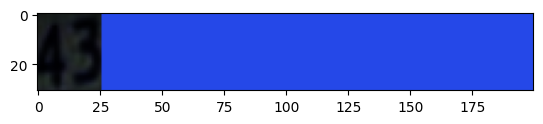

In [17]:
# Sanity check
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

# Callbacks for early termination, loss plateau and CSVLogger with TensorBoard 

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

callbacks = [
    # Early stopping based on validation loss
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=15, restore_best_weights=True),

    # Save the model with the best validation accuracy
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/models/recognizer_svhn_best.h5', monitor='val_loss', save_best_only=True, mode='min'),

    # Log training data for later analysis
    tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/models/recognizer_svhn.csv'),

    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1),

    # TensorBoard for visualization
    TensorBoard(log_dir='/content/drive/MyDrive/models/logs', histogram_freq=1, write_graph=True, write_images=True)
]

history = recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=100,
)

Epoch 1/100


<ipython-input-9-cc16c1a22bd8>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = recognizer.training_model.fit_generator(


3340/3340 [==============================] - 93s 28ms/step - loss: 0.4684 - accuracy: 0.8767 - val_loss: 0.7549 - val_accuracy: 0.8434 - lr: 1.0000e-05
Epoch 2/100
3340/3340 [==============================] - 93s 28ms/step - loss: 0.4518 - accuracy: 0.8765 - val_loss: 0.7502 - val_accuracy: 0.8386 - lr: 1.0000e-05
Epoch 3/100
3340/3340 [==============================] - 93s 28ms/step - loss: 0.4435 - accuracy: 0.8810 - val_loss: 0.7408 - val_accuracy: 0.8409 - lr: 1.0000e-05
Epoch 4/100
3340/3340 [==============================] - 93s 28ms/step - loss: 0.4323 - accuracy: 0.8829 - val_loss: 0.7211 - val_accuracy: 0.8463 - lr: 1.0000e-05
Epoch 5/100
1406/3340 [===========>..................] - ETA: 46s - loss: 0.4092 - accuracy: 0.8883

# Run inference

1/1 [==============================] - 2s 2s/step
Predicted: 699, Actual: 903


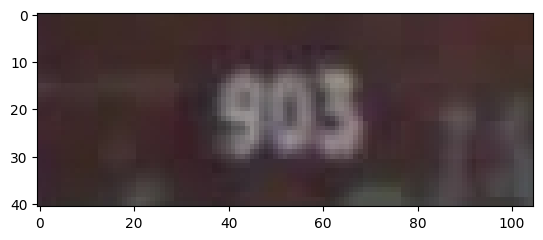

In [8]:
# Inference on a test sample
image_filepath, _, actual = test_labels[5000]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))